# 品質識別モデル構築
ダンボール箱の良品・不良品を識別するモデルの作成
- モデル生成の学習の実装
- 生成したモデルを利用した推論の実装
- 生成したモデルの性能評価レポートの作成

### 目次

1. 概要
 - 画像データ
 - ディレクトリ構成
 - 開発環境
2. データ取得
 - 初期設定
 - 画像データの配列変換
 - データ加工
 - データ分割
3. モデル作成
 - MobileNetの読み込み
 - 全結合層の新規作成
 - ネットワーク再定義
 - Fine-tuning
 - Data Augmentation（データ拡張）
 - Callback（コールバック関数）
 - モデル学習
 - 学習曲線のプロット
 - 学習曲線からの考察
 - モデル評価
 - モデル保存
4. モデル性能評価
 - 混同行列作成
 - 混同行列からの考察
 - ROC曲線のプロット
 - ROC曲線からの考察
 - モデル性能評価まとめ


## 1. 概要

モデル作成には、軽量で処理速度が速く、比較的精度の高い MobileNet を採用  
**Keras 学習済みモデルの MobileNet を Fine-tuning** させ、  良品・不良品の二項分類モデルを作成

個人的に各種モデルの精度を検証した過去記事を記載  
■ Keras 学習済みモデルを Fine-tuning させて精度比較  
https://qiita.com/ha9kberry/items/daa2fc330c71485b2c27

 


### 画像データ
- 良品画像
 - OKディレクトリ内に格納
 - 枚数：187枚
- 不良品画像
 - NGディレクトリ内に格納
 - 枚数：186枚
- 解像度：72
- 画像サイズ：4032 x 3024
- RGB

良品不良品の偏りのない綺麗なデータであることがわかる

### ディレクトリ構成
box_classification/  
　┣ box_classification.ipynb  
　┣ model/（学習済みモデルの保存先）  
　　┣ model-opt.hdf5（予測専用の軽量学習済みモデル）  
　　┗ model.hdf5（学習済みモデル）  
　┗ box-images/  
　　┣ NG/  
　　┗ OK/  

### 開発環境
AWS EC2 スポットインスタンス
- AMI：Deep Learning AMI (Ubuntu) Version 20.0
- インスタンスタイプ：p2.xlarge（GPU compute）
- 仮想環境：tensorflow_p36

※ ローカル環境で実行する場合
- MacBook Pro Mojave 10.14.4
- Python 3.6.8
- anaconda3-5.2.0
- 必要なパッケージのインストール
 - pip install scikit-learn
 - pip install tensorflow
 - pip install keras
 - pip install Pillow

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = {'png', 'retina'}

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/font_manager.py:278: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [3]:
import os, glob
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.applications.mobilenet import MobileNet
from keras.models import Model, load_model
from keras.layers.core import Dense
from keras.layers.pooling import GlobalAveragePooling2D
from keras.optimizers import Adam, RMSprop, SGD
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


## 2. データ取得
### 初期設定

クラスは OK、NG の２クラス  
画像サイズは Keras 学習済み MobileNet が指定する最大のサイズである 224 x 224 にリサイズ

In [11]:
class_list = ['OK','NG']
img_dir = 'box-images/'
img_width, img_height = 224, 224

### 画像データの配列変換
良品・不良品の画像データを読み込み、配列データに変換  
OKは０、NGは１にラベリング

In [12]:
def im2array():
    X = []
    y = []
    for class_name in class_list:
        file_list = glob.glob(img_dir + class_name + '/*')
        for i, file_path in enumerate(file_list):
            im = Image.open(file_path)
            im = im.resize((img_width, img_height))
            data = np.asarray(im)
            X.append(data)
            y.append(class_list.index(class_name))
    X = np.array(X)
    y = np.array(y)
    return X, y

In [13]:
%%time
X, y = im2array()
print('X.shape : ', X.shape)
print('y.shape : ', y.shape)

X.shape :  (373, 224, 224, 3)
y.shape :  (373,)
CPU times: user 1min 2s, sys: 6.08 s, total: 1min 9s
Wall time: 1min 9s


### データ加工

In [14]:
# データ型の変換＆正規化
X = X.astype('float32') / 255
# one-hot表現に変換
num_classes = len(class_list)
y = to_categorical(y, num_classes = num_classes)
print('X.shape : ', X.shape)
print('y.shape : ', y.shape)

X.shape :  (373, 224, 224, 3)
y.shape :  (373, 2)


### データ分割
データセットをtrainデータ / validデータ / testデータに分割  
各データに偏りがないよう、正解ラベルによる**層化サンプリング（stratify）**をパラメータに実装  
（正解ラベルに偏りがあると、少数ラベルの分類精度が低いモデルになる）


In [15]:
# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    random_state = 0,
    stratify =y,
    test_size = 0.2
)
# trainからvalidを分割
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train,
    y_train,
    random_state = 0,
    stratify =y_train,
    test_size = 0.2
)
print('X_train.shape : ', X_train.shape)
print('y_train.shape : ', y_train.shape)
print('X_valid.shape : ', X_valid.shape)
print('y_valid.shape : ', y_valid.shape)
print('X_test.shape : ', X_test.shape)
print('y_test.shape : ', y_test.shape)

X_train.shape :  (238, 224, 224, 3)
y_train.shape :  (238, 2)
X_valid.shape :  (60, 224, 224, 3)
y_valid.shape :  (60, 2)
X_test.shape :  (75, 224, 224, 3)
y_test.shape :  (75, 2)


In [16]:
# 正解ラベルが偏りなく分類できているか確認
print('y_train_0 : ', sum(y_train[:,0] == 0))
print('y_train_1 : ', sum(y_train[:,0] == 1))
print('y_valid_0 : ', sum(y_valid[:,0] == 0))
print('y_valid_1 : ', sum(y_valid[:,0] == 1))
print('y_test_0 : ', sum(y_test[:,0] == 0))
print('y_test_1 : ', sum(y_test[:,0] == 1))

y_train_0 :  119
y_train_1 :  119
y_valid_0 :  30
y_valid_1 :  30
y_test_0 :  37
y_test_1 :  38


偏りなく分割できている

## 3. モデル作成

### MobileNetの読み込み
Keras 学習済みモデルの MobileNet を読み込む  
- 新たに二項分類モデルを構築するため、ネットワークの出力層側にある全結合層の除去（include_top = False）  
- ImageNetで学習した重みを使用（weights = 'imagenet'）

In [17]:
base_model = MobileNet(
    include_top = False,
    weights = 'imagenet',
    input_shape = (img_width, img_height, 3)
)

17227776/17225924 [==============================] - 3s 0us/step


### 全結合層の新規作成
二項分類させるための全結合層を新たに作成

** GlobalAveragePooling2D **  
各特徴マップごとに平均値を算出し１次元に変換（各特徴マップのサイズは1×1）  
この後の全結合層につなぐことができる

In [18]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation = 'relu')(x)
predictions = Dense(num_classes, activation = 'softmax')(x)

### ネットワーク再定義
新たな全結合層を出力層側に実装し MobileNet ネットワークを再定義

In [19]:
model = Model(inputs = base_model.input, outputs = predictions)
print('{}層'.format(len(model.layers)))

90層


### Fine-tuning

MobileNet を新たな画像データで Fine-tuning  
一般的に CNN では**浅い層ほど色やエッジ、ブロブなど汎用的な特徴が抽出**され、**深い層ほど学習データに特化した特徴が抽出**される傾向にある  
そこで浅い層の（すでに ImageNet で学習した）汎用的な特徴抽出はそのまま固定（freeze）させ、深い層の重みのみタスクに合わせて再学習させる

- 全90層のうち、およそ8割にあたる**入力層側72層を freeze**
- ただし、ミニバッチの正規化は必要なので、**Batch Normalization は freeze を解除**させる。
- 上記を除く、およそ**2割の層内にある畳み込み層と全結合層の重みを学習**させる。

In [20]:
# 72層までfreeze
for layer in model.layers[:72]:
    layer.trainable = False

    # Batch Normalization の freeze解除
    if 'bn' in layer.name:
        layer.trainable = True

#73層以降、学習させる
for layer in model.layers[72:]:
    layer.trainable = True

# layer.trainableの設定後にcompile
model.compile(
    optimizer = Adam(),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

### Data Augmentation（データ拡張）
画像データが比較的少なく、学習モデル生成の際、過学習を引き起こす可能性が想定される  
過学習を緩和するため、学習データからのミニバッチごとに指定した変換処理を加えるデータの水増し（データ拡張）を実装  
水増しすることで、同じデータでの学習がなくなり、汎化性能が改善される傾向にある

In [21]:
datagen = ImageDataGenerator(
    featurewise_center = False,
    samplewise_center = False,
    featurewise_std_normalization = False,
    samplewise_std_normalization = False,
    zca_whitening = False,
    # -10°〜10°の回転移動
    rotation_range = 10,
    # -10%〜10%の左右平行移動
    width_shift_range = 0.1,
    # -10%〜10%の上下平行移動
    height_shift_range = 0.1,
    # ランダムに左右反転
    horizontal_flip = True,
    # ランダムに上下反転
    vertical_flip = True
)

### Callback（コールバック関数）

**EarlyStopping**  
監視する値の変化が停止した時に学習を終了させることで （モデルの精度との直接的な関係性はないが）無駄な学習時間を減らすことができる

**ReduceLROnPlateau**  
監視する値の改善が止まった時に学習率を減らすことで、より効率的に精度の高いモデルを生成することができる

In [22]:
# EarlyStopping
early_stopping = EarlyStopping(
    # 監視する値
    monitor='val_loss',
    # 値が改善しなくなってからのエポック数
    patience=10,
    verbose=1
)

# ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    # 監視する値
    monitor='val_loss',
    # 値が改善しなくなってからのエポック数
    patience=3,
    # 学習率を減らす割合
    factor=0.1,
    verbose=1
)

### モデル学習

In [23]:
%%time
hist = model.fit_generator(
    datagen.flow(X_train, y_train, batch_size = 32),
    steps_per_epoch = X_train.shape[0] // 32,
    epochs = 50,
    validation_data = (X_valid, y_valid),
    callbacks = [early_stopping, reduce_lr],
    shuffle = True,
    verbose = 1
)

Epoch 1/50
7/7 [==============================] - 45s 6s/step - loss: 2.2059 - acc: 0.5714 - val_loss: 0.4383 - val_acc: 0.8500
Epoch 2/50
7/7 [==============================] - 2s 294ms/step - loss: 0.9051 - acc: 0.7001 - val_loss: 2.0663 - val_acc: 0.5333
Epoch 3/50
7/7 [==============================] - 2s 234ms/step - loss: 0.6781 - acc: 0.7357 - val_loss: 0.3447 - val_acc: 0.8833
Epoch 4/50
7/7 [==============================] - 2s 234ms/step - loss: 0.4178 - acc: 0.8195 - val_loss: 0.3443 - val_acc: 0.8667
Epoch 5/50
7/7 [==============================] - 2s 235ms/step - loss: 0.4581 - acc: 0.7728 - val_loss: 0.3961 - val_acc: 0.8333
Epoch 6/50
7/7 [==============================] - 2s 233ms/step - loss: 0.2953 - acc: 0.8591 - val_loss: 0.3631 - val_acc: 0.8833
Epoch 7/50
7/7 [==============================] - 2s 291ms/step - loss: 0.3647 - acc: 0.8214 - val_loss: 0.3900 - val_acc: 0.8500

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 8/50

### 学習曲線のプロット
各エポックごとのモデルの Accuracy（精度）と Loss（損失値）の学習曲線をプロット

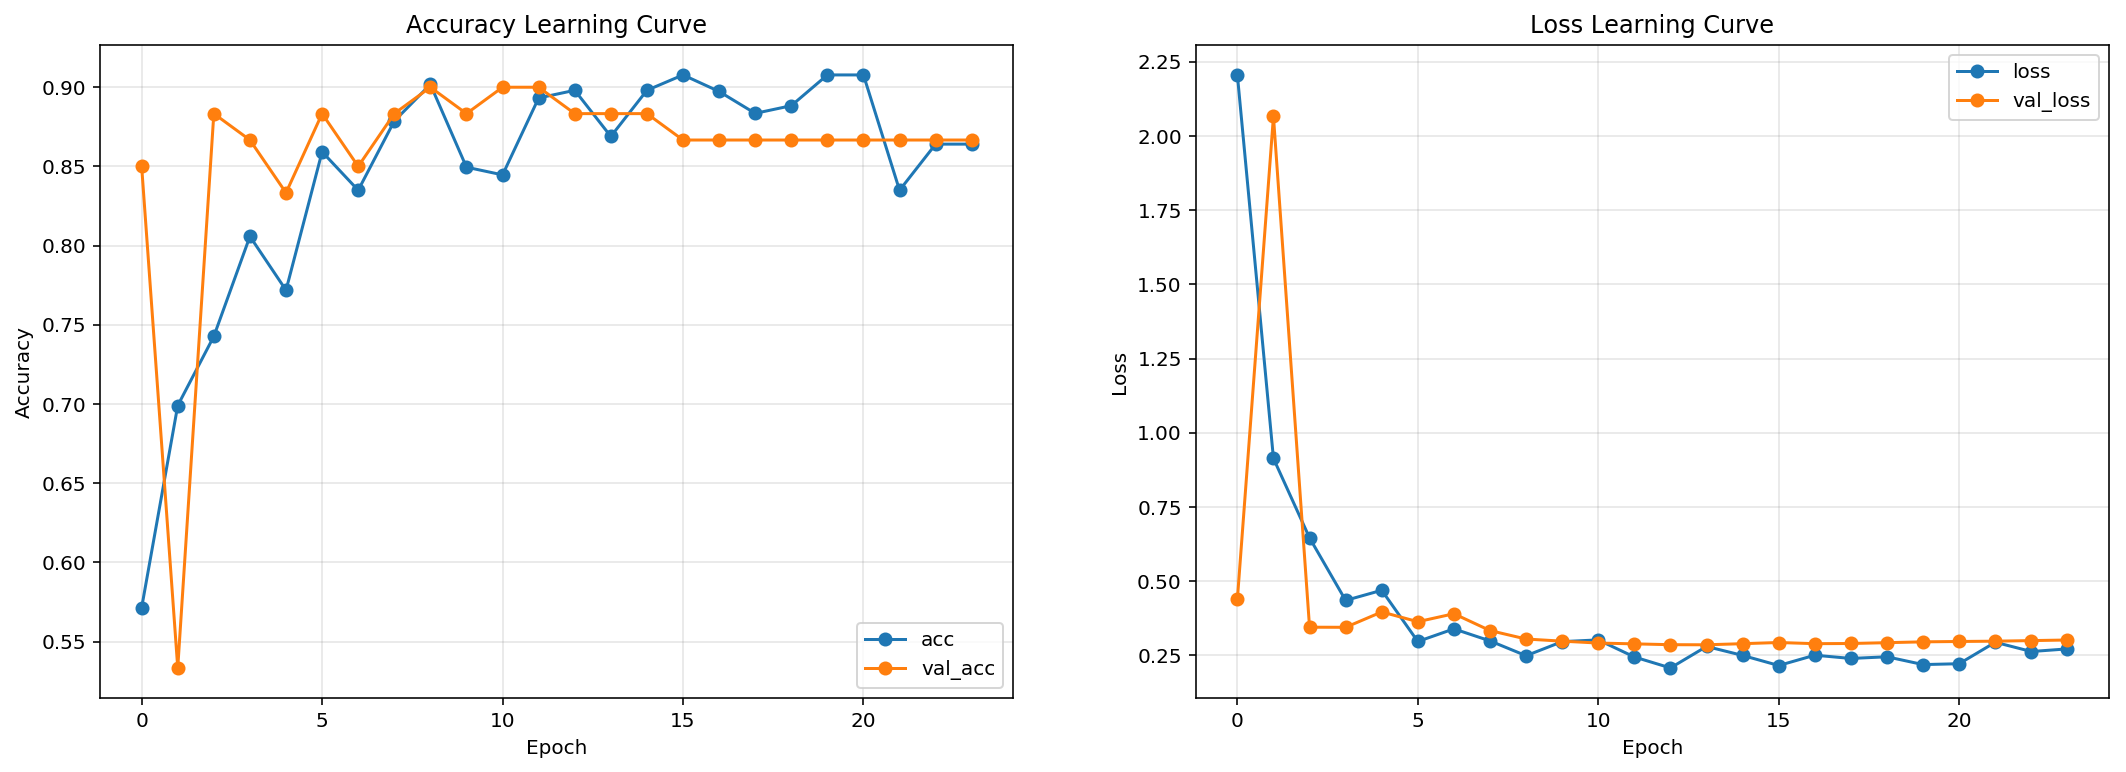

In [25]:
plt.figure(figsize = (18,6))

# accuracy
plt.subplot(1, 2, 1)
plt.plot(hist.history['acc'], label = 'acc', marker = 'o')
plt.plot(hist.history['val_acc'], label = 'val_acc', marker = 'o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Learning Curve')
plt.legend(loc = 'best')
plt.grid(color = 'gray', alpha = 0.2)

# loss
plt.subplot(1, 2, 2)
plt.plot(hist.history['loss'], label = 'loss', marker = 'o')
plt.plot(hist.history['val_loss'], label = 'val_loss', marker = 'o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Learning Curve')
plt.legend(loc = 'best')
plt.grid(color = 'gray', alpha = 0.2)

plt.show()

### 学習曲線からの考察

学習曲線から判断する限り、極端な過学習なく収束しており、Accuracy, Loss ともに決して悪い数値ではないと考える。  
Accuracy 学習曲線の上下振動に着目する。考えられる要因として下記を挙げる。

- 学習率が高い。学習のたびに損失関数の最適解を跨いで反復するため、loss をなかなか下げることができない。
- 最適な optimizer ではない。
- データ拡張しているとはいえ、そもそも画像データが少ない。（未学習の観点からも同様のことが言える）

以上を解決することで、より高精度での収束が期待できる。



### モデル評価
testデータを使って学習モデルの汎化精度を確認

In [26]:
score = model.evaluate(X_test, y_test, verbose=1)
print('evaluate loss: {0[0]}'.format(score))
print('evaluate acc: {0[1]}'.format(score))

75/75 [==============================] - 0s 6ms/step
evaluate loss: 0.27552801559368767
evaluate acc: 0.88


### モデル保存

In [27]:
model_dir = './model/'
if os.path.exists(model_dir) == False:os.mkdir(model_dir)
# 学習済みモデル保存
model.save(model_dir + 'model.hdf5')
# optimizerのない学習済み軽量モデルを保存（学習や評価は不可だが、予測は可能）
model.save(model_dir + 'model-opt.hdf5', include_optimizer = False)

In [ ]:
# 学習済みモデルを読み込む場合
#model = load_model(model_dir + 'model.hdf5')
# ptimizerのない学習済み軽量モデルを読み込む場合
#model = load_model(model_dir + 'model-opt.hdf5', compile = False)

## 4. モデル性能評価

In [28]:
# testデータの予測確率から1次元配列の予測ラベルを作成（閾値：0.5）
y_prob = model.predict(X_test)
y_pred = np.argmax(y_prob,axis=1)
y_pred

array([1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 0])

In [29]:
# testデータの正解ラベルを one-hot 表現から１次元配列に変換
y_test = np.argmax(y_test,axis=1)
y_test

array([1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 0])

### 混同行列作成

testデータの予測ラベル（閾値：0.5）と正解ラベルから混合行列を作成

| | Positive（不良品予測） | Negative（良品予測） |
| ---- | ---- | ---- |
| True（不良品） | TP（真陽性） | FN（偽陰性） |
| False（良品） | FP（偽陽性） | TN（真陰性） |

In [30]:
# 混同行列作成
from sklearn.metrics import confusion_matrix
labels=[1, 0]
conf_mat=confusion_matrix(y_test, y_pred, labels)
conf_mat

array([[34,  3],
       [ 6, 32]])

In [31]:
# 混同行列指標
(TP, FN, FP, TN) = conf_mat.ravel()
print('真陽性：',TP)
print('偽陰性：',FN)
print('偽陽性：',FP)
print('真陰性：',TN)

真陽性： 34
偽陰性： 3
偽陽性： 6
真陰性： 32


### 混同行列からの考察
真陽性=34, 真陰性=32 が偽陰性=3, 偽陽性=6 に比べ、高い数値を計測しており、**良品・不良品をそれぞれに振り分ける能力が相対的に高いモデル**であることがわかる。（前述のモデル評価で Accuracy を確認しているが）混同行列から精度を算出してみる。

In [32]:
# Accuracy（精度）
print('Accuracy（精度）：', (TP + TN) / (TP + FN + FP + TN))

Accuracy（精度）： 0.88


だが本課題は品質識別であり、いくら精度が高くても、**どれだけ不良品を取りこぼさないで分類できたか（再現率）が重要**である。  
つまり良品を良品と予測することはそれほど重要ではなく、良品を不良品と予測する割合が多少高くても、大きな問題ではない。

その観点から混同行列をもう一度見てみると、偽陰性=3, 偽陽性=6 ということで、不良品を良品と予測している数のほうが、良品を不良品と予測している数よりも相対的に少ない。混同行列から再現率・適合率を算出してみると、**再現率が相対的に高いモデル**であることがわかる。

In [33]:
# Recall（再現率）
print('Recall（再現率）：', TP  / (TP + FN))
# Precision（適合率）
print('Precision（適合率）：', TP / (TP + FP))

Recall（再現率）： 0.918918918918919
Precision（適合率）： 0.85


精度=0.88に着目すると、100箱中88箱、良品・不良品を振り分けることができるモデルということになるが、本課題の目的に即して、再現率=0.91に着目すると、100箱の不良品から91箱の不良品を予測することができるモデルということになる。

また適合率=0.85についても言及すると、不良品100箱を予測した場合、その中に良品が15箱混じっていることになる。不良品100箱を再検査するコストに比べて、ダンボール1箱の単価が取るに足らないのであれば、そのまま無視していいのだが、そうでないのであれば適合率も重要な評価指標になる。  
その場合、学習モデルの性能を比較評価する際の指標として、再現率・適合率ともに着目したF-measure（F値）も必要になってくる。

In [34]:
# F-measure（F値）
recall = TP  / (TP + FN)
precision = TP / (TP + FP)
print('F-measure（F値）：', 2 * (precision * recall) / (precision + recall))

F-measure（F値）： 0.8831168831168831


### ROC曲線のプロット

test データの予測確率と正解ラベルから各閾値ごとの FPR（偽陽性率）, TPR（真陽性率）を算出し ROC曲線をプロット  
また学習モデルの性能を比較評価する際の指標として AUC（ROC曲線下面積）も出力する

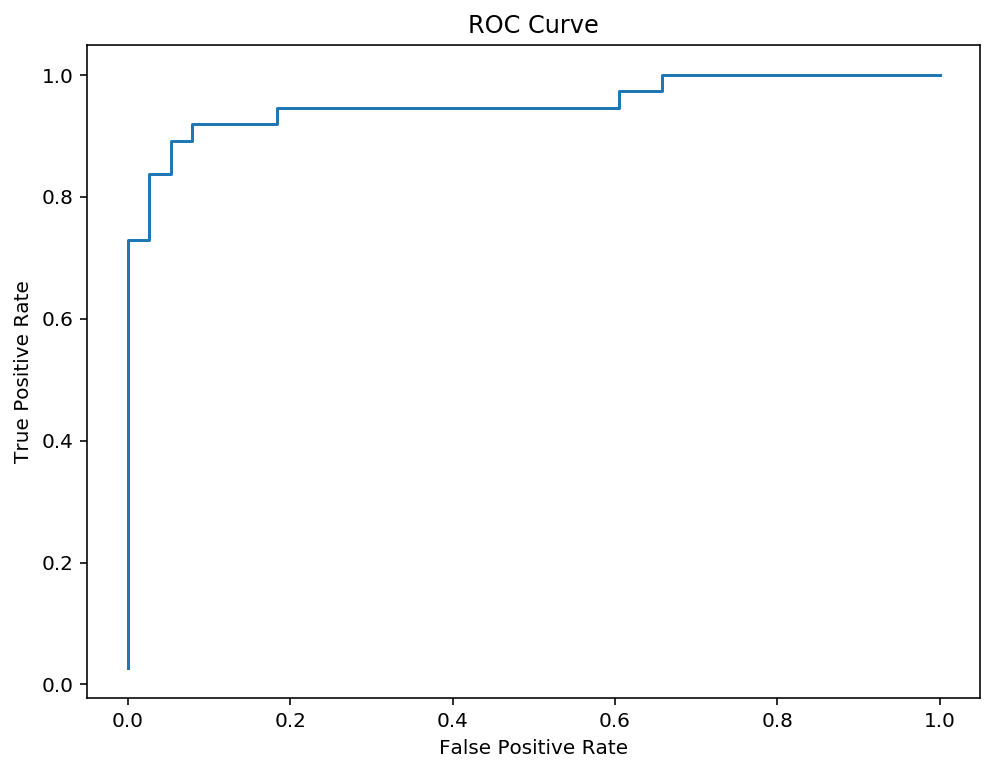

AUC： 0.9530583214793742


In [35]:
# ROC曲線
from sklearn.metrics import roc_curve
FPR, TPR, thresholds= roc_curve(y_test, y_prob[:,1])
plt.figure(figsize=(8,6))
plt.plot(FPR, TPR)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

# AUC
from sklearn.metrics import auc
print('AUC：', auc(FPR, TPR))

In [36]:
# 閾値
thresholds

array([0.99999225, 0.9720871 , 0.94792205, 0.88776463, 0.8751079 ,
       0.84828377, 0.7431593 , 0.6789197 , 0.49340355, 0.4294763 ,
       0.08352467, 0.07364784, 0.05312658, 0.04410998, 0.00166341],
      dtype=float32)

### ★ ROC曲線からの考察

ROC曲線は左から右に閾値が高い順に真陽性率, 偽陽性率をプロットした曲線である。  
閾値が高い時点で真陽性率（=再現率）も高い値を計測しており、これは**高い予測確率で不良品の中から不良品を分類しているケースが多いモデル**であることがわかる。

一般的に偏りがあるデータでモデルを学習させると、たとえ精度の数値が良くても、少数派の分類の予測確率が下がり、高閾値での真陽性率が下がり、AUCが低くなる傾向がある。今回もともとの画像データやデータ分割に偏りはなく、その効果があらわれているように思う。

### モデル性能評価まとめ

- 良品・不良品をそれぞれに振り分ける能力が相対的に高いモデルではあるが、精度 0.88 を計測。
- 本課題は、どれだけ不良品を取りこぼさないで分類できたかが重要であると考え、再現率を確認すると 0.91 を計測。  
再現率が相対的に高いモデルと言える。
- ROC曲線から、高い予測確率で不良品の中から不良品を分類しているケースが多いモデルと言え、AUC も 0.95 と高い。